![Tanzania](https://www.wvi.org/sites/default/files/2022-06/Water%20for%20Change%20-%20Tanzania.png)
# <center> Phase 3 Project: Tanzanian Water Wells <center>
   <center>  By: Keanan Ginell

# Business Problem

Having access to water is a basic human right. The government of Tanzania have asked me to create a model that will help predict wells that are in need of repair. 

In [222]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score,cross_validate, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import plot_confusion_matrix, classification_report, log_loss, confusion_matrix,\
                            plot_roc_curve, precision_score, recall_score, accuracy_score, f1_score,\
                            roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

In [82]:
df_test = pd.read_csv('data/Test_data.csv')
df_train_labels= pd.read_csv('data/training_label.csv')
df_train_values = pd.read_csv('data/training_values.csv')

# Data Overview

Data for this project was received from [Tanzanian Water Wells](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/)

Descriptions of Features is located in jupyter notebook Data_overview.ipynb

In [3]:
df_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [348]:
df_train_labels['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [4]:
df_train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

**Observations**
- date_recorded, construction_year likely needs to be changed to datetime
- several nulls
- columns need to be checked for usability  

# Data Preprocessing

1. Checking for null values and duplicates
2. Checking for usable columns

### Data Cleaning Summary

1. Training values and labels can be joined along id column



2. Columns deemed irrelevant to wells functionality:
    1. date_recorded - (The date the data was entered, ranges from 2002-2013)
    2. funder - (who funded the well)
    3. wpt_name* - (name of water wells)


*Denotes columns dropped but aree useful for further analysis or presentation




Potential drops:
2. num_private
3. 

## Null and duplicates check

In [5]:
def data_prep(df):
    # Checks for nulls
    print('\033[01mNull Values:\033[0m')
    x = 0
    for k,y in df.isna().sum().items():
        if y != 0:
            print(f'\033[31m{k}\033[00m: {y}') 
            x += 1
    if x == 0:
        print('No Nulls')
        
    # Prints number of duplicates
    print(f'\n\033[01mNumber of Duplicates: {df.duplicated().sum()}')
    # Displays duplicated rows
    df.loc[df.duplicated() == True]

In [6]:
data_prep(df_train_values)

Null Values:
funder: 3635
installer: 3655
subvillage: 371
public_meeting: 3334
scheme_management: 3877
scheme_name: 28166
permit: 3056

Number of Duplicates: 0


In [7]:
data_prep(df_train_labels)

Null Values:
No Nulls

Number of Duplicates: 0


In [8]:
data_prep(df_test)

Null Values:
funder: 869
installer: 877
subvillage: 99
public_meeting: 821
scheme_management: 969
scheme_name: 7092
permit: 737

Number of Duplicates: 0


**Notes:**
- No duplicates
- training values and test data have nulls in the same columns


## Analyzing Features

In [9]:
# Checking if id column is joinable
df_train_values['id'].sum() == df_train_labels['id'].sum()

True

In [10]:
# Creating a sample df with columns as rows, to further understand each feature
features_sample = df_train_values.head(1).T.reset_index()
features_sample.index.name = 'index'
features_sample.columns = ['Feature', 'sample']

display(pd.concat([features_sample.iloc[0:20],
                   features_sample.iloc[20:47].reset_index()],axis=1))

,Feature,sample,index,Feature,sample
0,id,69572,20,scheme_management,VWC
1,amount_tsh,6000,21,scheme_name,Roman
2,date_recorded,2011-03-14,22,permit,False
3,funder,Roman,23,construction_year,1999
4,gps_height,1390,24,extraction_type,gravity
5,installer,Roman,25,extraction_type_group,gravity
6,longitude,34.9381,26,extraction_type_class,gravity
7,latitude,-9.85632,27,management,vwc
8,wpt_name,none,28,management_group,user-group
9,num_private,0,29,payment,pay annually


### Irrelevant Data: based on description
1. date_recorded - (The date the data was entered, ranges from 2002-2013)
2. funder - (who funded the well)
3. wpt_name* - (name of water wells)
4. lat and long
5. public_meeting (boolean)
6. recorded_by
7. permit 
*Denotes columns dropped but aree useful for further analysis or presentation


In [11]:
# Checking amount_tsh data
df_train_values['amount_tsh'].value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

Lots of zeros, which is weird because aamount_tsh represents the Total Static Head or the total amount of water available in the well. Zeros would indicate the well to not be functional

- Going to drop scheme_name due to large number of nulls, and provides same context as scheme_management

In [12]:
# Futher analyzing amount_tsh to the functionaliy of a well
df_train_values.loc[df_train_values['amount_tsh'] == 0.0].groupby(df_train_labels['status_group']).size()

status_group
functional                 19706
functional needs repair     3048
non functional             18885
dtype: int64

- There are 19k functional wells but amount_tsh indicates 41k wells are dry
- This either means a miss understanding of amount_tsh by me or those collecting the data, or just incorrect data.
- 0.0 could also likley mean null data

- This is a likley a poor indicator of if a well needs a repair but rather an indicator if a well should be repaired. This feature will be important when making final recommendations.

Below I check if any TSH values are greater then 0, additionally I check if any subregions contain wells with potentially more accurate tsh recordings.

In [13]:
# Checking if any non functional wells have TSH values greater then 0, T
df_train_labels.loc[df_train_labels['status_group']=='non functional'].groupby(df_train_values['amount_tsh']).size()

amount_tsh
0.0         18885
0.2             3
1.0             3
5.0            46
6.0            13
7.0            15
9.0             1
10.0          167
15.0            1
20.0          417
25.0           58
30.0          180
35.0            2
40.0           11
50.0          731
59.0            1
60.0            1
70.0           14
100.0         199
150.0          14
200.0         311
250.0         113
300.0         141
306.0           1
400.0          12
450.0           5
500.0         602
520.0           1
550.0           3
600.0          38
700.0          17
750.0          12
1000.0        281
1200.0         31
1500.0         33
2000.0        151
2400.0         45
2500.0         45
2800.0          1
3000.0         56
3500.0          1
3600.0          9
4000.0         30
5000.0         62
6000.0         27
7000.0          2
8000.0          8
9000.0          1
10000.0         8
11000.0         1
12000.0         4
13000.0         1
14000.0         1
15000.0         1
20000.0         3

In [14]:
# Checking if any subregions have no 0 TSH values 
def tsh_checker():
    '''
    Checks all the location based columns to check if any location feature has no amount_tsh values
    '''
    print('Subregion contains 0.0 TSH wells:')
    # Creating list of subregions that have a amount_tsh of 0.0, subvillages is removed b/c of nulls
    locations = ['basin','region','region_code','district_code','lga','ward']
    for loc in locations:
        # list of subregions wiith 0.0 tsh wells
        bad_tsh = [k for k,y in df_train_values.loc[df_train_values['amount_tsh'] == 0.0][loc].value_counts().items()]
        # list of of all subregions 
        subregions = sorted(list(df_train_values[loc].unique()))
    # Checking if both lists are the same
        if sorted(list(set(bad_tsh))) == subregions:
            print(f'{loc}: {False}')
        else:
            print(f'{loc}: {True}')
            tsh_df = df_train_values.drop(df_train_values.loc[df_train_values[loc].isin(bad_tsh)].index) 
            return(tsh_df)

In [15]:
tsh_df = tsh_checker()

Subregion contains 0.0 TSH wells:
basin: False
region: False
region_code: False
district_code: False
lga: False
ward: True


In [16]:
tsh_df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
26,55012,500.0,2013-01-16,Sobodo,200,Kilolo Star,39.370777,-9.942532,Ruhoma Primary School,0,...,monthly,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
40,70238,25.0,2013-10-03,Ces(gmbh),710,DWE,37.420027,-3.476849,Kwa Lusina,0,...,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
41,12796,500.0,2011-03-12,Government Of Tanzania,2469,Commu,33.927902,-9.204649,none,0,...,on failure,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
50,3228,20.0,2013-02-21,Muwsa,783,MUWSA,37.372858,-3.349292,Upendo,0,...,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
96,68554,500.0,2013-02-11,Government Of Tanzania,1274,Government,30.126681,-4.236378,Kwa Nyonyori,0,...,other,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59313,5355,200.0,2013-02-15,Kidp,1228,KIDP,30.144578,-4.536961,Ccm,0,...,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
59314,64507,6000.0,2011-03-03,Danida,1542,DANID,35.571335,-7.868329,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59330,46438,10.0,2013-06-03,Germany Republi,1137,CES,37.186804,-3.276779,Area 17 Namba 48,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59367,73019,2000.0,2011-03-09,Government Of Tanzania,1977,Commu,34.338899,-9.565553,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [17]:
# Checking funder data
df_train_values['funder'].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
H4ccp                        1
Redet                        1
Makonder                     1
Icap                         1
Chacha Issame                1
Name: funder, Length: 1897, dtype: int64

Funder data contain 3635 null values, futhermore the impact a funder has on well condition is likley due to complicated underlying reasons. The installer for example will have a more direct impact and is likely already Influenced by the funder. Going to attempt one data set using this feature.

In [18]:
# Checking gps height data
df_train_values['gps_height'].value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

No units given that max is 2770 it is 99% likley to be in meters.
GPS data contains mostly 0 which is very unlikley, I will be plotting a elevation map to confirm this, 
- dropped for main list

In [19]:
# Checking installer data
df_train_values['installer'].value_counts()

DWE                17402
Government          1825
RWE                 1206
Commu               1060
DANIDA              1050
                   ...  
Wedeco                 1
Teonas Wambura         1
SUNAMCO                1
KDC                    1
RESOLUTE MINING        1
Name: installer, Length: 2145, dtype: int64

- 3655 null values
- Going to drop from main list

In [20]:
# Checking num_private data
# no explanation given, likely government vs privately funded or maintained well
df_train_values['num_private'].value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

- No indication what 0 represents likeley indicates a governement funded or maintained well
- review

In [21]:
# Checking population data
df_train_values['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

- Could be indicator of how often a well is used, given the large amount of nulls this data features accuracy is questionable. unlikley to give an accurate.
- Population is defined as population around the well not necessarily the population that uses the well. 

In [22]:
# Checking scheme_management data
df_train_values['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

- 3800 nulls, going to keep for now 

In [23]:
# Checking construction_year data
df_train_values['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [77]:
df_train_values['date_recorded'].min()

'2002-10-14'

20709 points are missing construction year. While important given the large value of nulls, I will be dropping

In [24]:
# Checking extraction data
extraction = df_train_values[['extraction_type_group','extraction_type_class','extraction_type']]
for feature in extraction.columns:
    print(f'\033[01m{feature}\033[00m\n{extraction[feature].value_counts()}\n')

extraction_type_group
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

extraction_type_class
gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

extraction_type
gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81           

All 3 features show the same meassage, will only keep 1.
- Extraction_type has the best resolution or most detailed, keeping extraction_type

In [25]:
# Checking management data
df_train_values['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [26]:
# Checking management data
df_train_values['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

Going to keep management and drop management_group, though if model is overfitting this will be swapped

In [27]:
# Checking payment data
df_train_values['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

Might be a good indication of local funding types, payment and payment_type seem to be the same
- dropping payment_type

In [28]:
# Checking water_quality data
df_train_values['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

Associated with quality_group, dropping quality_group and keeping water_quality

In [29]:
# Checking quantity data
df_train_values['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

Same as quantity_group, keeping quantity and dropping quantity_group

In [30]:
# Checking source data
df_train_values['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

Once again same information beeing conveyed as source_type and source_class,

Keeping source, unless overfitting and then will use source_class

In [31]:
# Checking waterpoint_type data
df_train_values['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

Same information as waterpoint_type_group, keeping waterpoint_type, dropping waterpoint_type_group

## Location Based Features
1. Check which location feature has the best resolution (aka. fewest wells in each feature or largest length), excluding lat and long
2. What does each location feature represent


In [32]:
location = df_train_values[['basin','subvillage','region','region_code',
                            'district_code','lga','ward']]

In [33]:
data_prep(location)

Null Values:
subvillage: 371

Number of Duplicates: 31795


In [34]:
for feature in location.columns:
    print(f'\033[01m{feature}\033[00m\n{location[feature].value_counts()}\n')

basin
Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

subvillage
Madukani         508
Shuleni          506
Majengo          502
Kati             373
Mtakuja          262
                ... 
Nyahnundu          1
Nepolisi           1
Miule Shuleni      1
Kumurumo           1
Ugowola A          1
Name: subvillage, Length: 19287, dtype: int64

region
Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808


**Notes:**
- Region and region code don't line up 
- subvillage contains several nulls 
- ward or subvillage appears to have the most resolution
- Seems odd that a subvillage has a higher well count then wards given that subvillages make up wards.
    - Several subvillage's have well counts of 500 while the highest well count for ward is 307.
    - The true scale and definition of subvillage is questionable

Used the following links to further understand the scale of each feature
[Tanzania Subdivisions](https://en.wikipedia.org/wiki/Subdivisions_of_Tanzania) and
[worldbank Tanzania - Region & District Boundary](https://datacatalog.worldbank.org/search/dataset/0039598)


In [35]:
# Checking scale of features
location.loc[df_train_values['ward'] == 'Mdandu']

,basin,subvillage,region,region_code,district_code,lga,ward
16,Rufiji,Kidudumo,Iringa,11,4,Njombe,Mdandu
194,Rufiji,Sadani,Iringa,11,4,Njombe,Mdandu
392,Rufiji,Kati,Iringa,11,4,Njombe,Mdandu
452,Rufiji,Mvinila,Iringa,11,4,Njombe,Mdandu
457,Rufiji,Uchiliwala,Iringa,11,4,Njombe,Mdandu
...,...,...,...,...,...,...,...
57729,Rufiji,Mawindi,Iringa,11,4,Njombe,Mdandu
57864,Rufiji,Kati,Iringa,11,4,Njombe,Mdandu
57969,Rufiji,Ngelele,Iringa,11,4,Njombe,Mdandu
58660,Rufiji,Kilolelo,Iringa,11,4,Njombe,Mdandu


### Understanding Location data
- Inorder for the lowest resolution or largest scale to the heightest resolution or smallest scale,
    - Basin, Region, Districts, lga, ward, and sub-village

- Due to null values, and unclear interpretation I am dropping sub villages
- Keeping basin and ward
- Going to create a second dataset using subvillages instead of ward and remove null values.
- lat and long will be dropped at the end such that they can easily be used for generating maps

# Creating Well Age Column

In [83]:
# Replacing construction years with value 0 to null 
df_train_values['construction_year'] = df_train_values['construction_year'].replace(0,np.nan)
# Changing to datetime format
df_train_values['date_recorded'] = pd.to_datetime(df_train_values['date_recorded']).dt.year.astype(int)

# Creating Age column based on input date and well construction year
df_train_values['well_age'] = df_train_values['date_recorded'] - df_train_values['construction_year']


In [84]:
# creating list of columns that will be dropped
# Creating list of columns to drop, final list descriptions below
drop = ['date_recorded','funder','wpt_name',
       'subvillage','region','region_code','district_code','lga',
       'gps_height','installer','population', 'public_meeting', 'recorded_by', 'scheme_name', 'permit',
       'construction_year', 'extraction_type_group', 'extraction_type_class', 'management_group',
       'payment_type', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']

drop2 = ['date_recorded','funder','wpt_name',
        'ward','region','region_code','district_code','lga',
        'gps_height', 'installer', 'population', 'public_meeting', 'recorded_by', 'scheme_name', 'permit',
        'construction_year', 'extraction_type_group', 'extraction_type_class', 'management_group',
        'payment_type', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']

drop3 = ['date_recorded','wpt_name', 
        'subvillage','region','region_code','district_code','lga',
        'population', 'public_meeting', 'recorded_by', 'scheme_name', 'permit', 'construction_year',
        'extraction_type_group', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group',
        'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']

# Swap 'management_group' with 'management' if overfitting, and 'source_class' with 'source'

**Drop Lists Information**

drop - main list of columns being dropped

drop2 - Using list: **drop**, dropping ward and adding subvillage

drop3 - Using list: **drop**, adding funder, gps_height, installer, 

1. build best model
2. try adding back in funder and just remove the nulls,
3. build model based on location that has no zeros for amount_tsh (region, ward, lga)

# Merge data sets

In [85]:
# Checking shape of df_train_values
df_train_values.shape

(59400, 41)

In [86]:
# Merging datasets
df_merged = df_train_values.merge(df_train_labels,how='left',on='id')
# Checking Shape after merge
df_merged.shape

(59400, 42)

In [87]:
# Function to drop columns and nulls
def dropper(df, drops):
    '''
    df : DataFrame
    drop : list of columns to drop
    '''
    drop = drops.copy()
    drop += ['latitude', 'longitude', 'id']
    df = df.drop(columns=drop, axis=1).reset_index(drop=True)
    df = df.dropna()
    return(df)

In [88]:
# new dataframes
df = dropper(df_merged, drop)
df2 = dropper(df_merged, drop2)
df3 = dropper(df_merged, drop3)

In [89]:
df3.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'num_private',
       'basin', 'ward', 'scheme_management', 'extraction_type', 'management',
       'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type',
       'well_age', 'status_group'],
      dtype='object')

# Train-test Split

In [1019]:
class model():
    def __init__(self, model, X, y):
        self.model = model
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=42)
        
        
        # .score()
        self.score = self.model.score(self.X_test, self.y_test)
        
        self.y_pred_train = self.model.predict(self.X_train)
        self.y_pred_test = self.model.predict(self.X_test)
        
        
        
    
    def cross_validate(self, cv_input=10,**kwargs):
        self.cvs_results = cross_val_score(X=self.X_train, y=self.y_train, estimator = self.model, cv=5,
                                           **kwargs).mean() 
#         self.cv_results = cross_validate(X=self.X_train, y=self.y_train, estimator = self.model,
#                                          cv=cv_input,return_train_score=True).mean()
        print(f'CV Results: {self.cvs_results}')
    
    def test_report(self):
        y_pred_test = self.model.predict(self.X_test)
        print(classification_report(self.y_test, y_pred_test))
        
    def aprf(self, **kwargs):
        # Accuracy, Precision, Recall, and F1-Score
        y_pred_train = self.model.predict(self.X_train)
        y_pred_test = self.model.predict(self.X_test)
        try:
            #accuracy
            self.train_accuracy = accuracy_score(self.y_train, y_pred_train)
            self.test_accuracy = accuracy_score(self.y_test, y_pred_test)
            print(f'Training Accuracy: {self.train_accuracy}')
            print(f'Testing Accuracy: {self.test_accuracy}')

            # Precision
            print(f'Training Precision: {precision_score(self.y_train, y_pred_train, **kwargs)}')
            print(f'Testing Precision: {precision_score(self.y_test, y_pred_test, **kwargs)}')

            # Recall
            self.train_recall = recall_score(self.y_train, y_pred_train, **kwargs)
            self.test_recall = recall_score(self.y_test, y_pred_test, **kwargs)
            print(f'Training Recall: {self.train_recall}')
            print(f'Testing Recall: {self.test_recall}')

            # F1-Score
            self.train_f1 = f1_score(self.y_train, y_pred_train, **kwargs)
            self.test_f1 = f1_score(self.y_test, y_pred_test, **kwargs)
            print(f'Training F1-Score: {self.train_f1}')
            print(f'Testing F1-Score: {self.test_f1}')
       
        except Exception as e:
            print("An error occurred:", e)


In [893]:
X = df3.drop(columns='status_group')
y = df3['status_group']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [894]:
y_train.value_counts(normalize=1)

functional                 0.569300
non functional             0.365127
functional needs repair    0.065574
Name: status_group, dtype: float64

# Baseline Model
- Dummy Model

In [896]:
dummy_model = DummyClassifier(strategy='most_frequent') #(strategy="constant",constant='non functional')
dummy_model.fit(X_train, y_train)
y_pred = dummy_model.predict(X_train)

In [897]:
cv_results = cross_val_score(dummy_model, X_train, y_train, cv=5)
cv_results.mean()

0.5692995518505216

54% accuraccy if we were to predict majority class

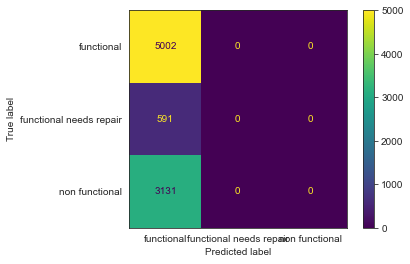

In [898]:
plot_confusion_matrix(dummy_model, X_test, y_test)

In [1020]:
baseline = model(dummy_model, X, y)

In [901]:
baseline.cross_validate()

CV Results: 0.5692995518505216


In [1003]:
baseline.aprf(average= 'weighted')

Training Accuracy: 0.5692995529061102
Testing Accuracy: 0.573360843649702
Training Precision: 0.32410198093909703
Testing Precision: 0.328742657030698


/Users/keanan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Recall: 0.5692995529061102
Testing Recall: 0.573360843649702
Training F1-Score: 0.4130530469328283
Testing F1-Score: 0.4178859012000305


# Class Imbalance
- Attempted using SMOTE in the pipeline, this had little to no impact on the model, removed due to extensive run time

# Building pipeline

In [919]:
# Numerics for scaling
df_num = list(df3.select_dtypes(include='number').columns)
# categoricals for one hot encoder
df_cat = list(df3.select_dtypes(include='object').columns)
df_cat.remove('status_group')

In [920]:
# use or don't use simpleImputer?
subpipe_num = Pipeline(steps=[('ss', StandardScaler())])

subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [921]:
CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, df_num),
                                         ('subpipe_cat', subpipe_cat, df_cat)],
                           remainder='passthrough')

In [116]:
logreg_model_pipe = Pipeline(steps=[('ct', CT),
                                    ('logreg', LogisticRegression(random_state=42, max_iter=100,n_jobs=-1))])
                                    
logreg_model_pipe.fit(X_train, y_train)
logreg_model_pipe.score(X_train, y_train)

0.8208185257365586

In [115]:
rfc_model_pipe = Pipeline(steps=[('ct', CT,), 
                                 ('rfc', RandomForestClassifier(random_state=42,n_jobs= -1,))])

rfc_model_pipe.fit(X_train, y_train)
rfc_model_pipe.score(X_train, y_train)

0.9938094692193052

In [101]:
dt_model_pipe = Pipeline(steps=[('ct', CT), 
                                   ('dt', DecisionTreeClassifier(random_state=42))])
dt_model_pipe.fit(X_train, y_train)
dt_model_pipe.score(X_train, y_train)

0.9938476823722725

# Model Evaluation

In [922]:
random_forest = model(rfc_model_pipe, X, y)

In [924]:
random_forest.test_report()

                         precision    recall  f1-score   support

             functional       0.83      0.86      0.84      5002
functional needs repair       0.43      0.31      0.36       591
         non functional       0.79      0.78      0.79      3131

               accuracy                           0.79      8724
              macro avg       0.68      0.65      0.66      8724
           weighted avg       0.79      0.79      0.79      8724



In [105]:
random_forest.cross_validate(n_jobs=4)

CV Results: 0.7909359644903623


In [925]:
trees = model(dt_model_pipe, X, y)

In [926]:
trees.test_report()

                         precision    recall  f1-score   support

             functional       0.81      0.81      0.81      5002
functional needs repair       0.36      0.33      0.34       591
         non functional       0.74      0.75      0.75      3131

               accuracy                           0.76      8724
              macro avg       0.64      0.63      0.63      8724
           weighted avg       0.76      0.76      0.76      8724



In [108]:
trees.cross_validate(n_jobs=-3)

CV Results: 0.7633461657344732


In [927]:
logreg = model(logreg_model_pipe, X, y)

In [929]:
logreg.test_report()

                         precision    recall  f1-score   support

             functional       0.80      0.89      0.84      5002
functional needs repair       0.54      0.19      0.28       591
         non functional       0.80      0.75      0.77      3131

               accuracy                           0.79      8724
              macro avg       0.71      0.61      0.63      8724
           weighted avg       0.78      0.79      0.78      8724



In [112]:
logreg.cross_validate(n_jobs = -3)

CV Results: 0.7889870221174361


All three models are very overfit
- Decision trees is the most overfit. 
- Random forest is the best model so far. Based on this I will be continuing with this model.

# Grid Search

In [168]:
params_grid = {"rfc__criterion": ["gini", "entropy"],
               "rfc__max_depth": [10, 20, 30, 40, 50],
               "rfc__min_samples_split": [2, 5, 10],
               "rfc__min_samples_leaf": [1, 5, 10, 15, 30, 50]
              }

In [169]:
gs = GridSearchCV(estimator=rfc_model_pipe,
                 param_grid= params_grid,
                 cv=5, verbose=3, n_jobs=-2)

In [170]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-2)]: Done 498 tasks      | elapsed: 68.7min
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed: 108.8min
[Parallel(n_jobs=-2)]: Done 900 out of 900 | elapsed: 124.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'num_private',
                                                                          'well_age']),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                   

In [171]:
gs.best_params_

{'rfc__criterion': 'gini',
 'rfc__max_depth': 50,
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 5}

In [174]:
gs.best_score_

0.808896219510512

This model is better, but can still be improved

# Grid search 2

In [176]:
params_grid = {"rfc__max_depth": [45,50,55,60,65,70],
               "rfc__min_samples_split": [4, 5, 6, 7],
               "rfc__min_samples_leaf": [1, 2, 3, 4, 5]
              }


In [177]:
gs = GridSearchCV(estimator=rfc_model_pipe,
                 param_grid= params_grid,
                 cv=5, verbose=3, n_jobs=-2)

In [178]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed: 60.8min
[Parallel(n_jobs=-2)]: Done 498 tasks      | elapsed: 109.0min
[Parallel(n_jobs=-2)]: Done 600 out of 600 | elapsed: 130.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'num_private',
                                                                          'well_age']),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                   

In [179]:
gs.best_params_

{'rfc__max_depth': 50, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 5}

In [180]:
gs.best_score_

0.808896219510512

In [ ]:
gs.cv_results_

In [930]:
grid_2 = model(gs, X, y)

In [931]:
grid_2.test_report()

                         precision    recall  f1-score   support

             functional       0.81      0.92      0.86      5002
functional needs repair       0.59      0.22      0.32       591
         non functional       0.84      0.76      0.80      3131

               accuracy                           0.81      8724
              macro avg       0.75      0.63      0.66      8724
           weighted avg       0.81      0.81      0.80      8724



Same results as above, going to attempt one more iteration

# Grid search 3

In [698]:
params_grid = {"rfc__max_depth": [50,55,60,65],
               "rfc__min_samples_split": [3, 4, 5, 6],
               'rfc__n_estimators': [100, 200, 300,400,500]
              }

In [699]:
gs3 = GridSearchCV(estimator=rfc_model_pipe,
                 param_grid= params_grid,
                 cv=5, verbose=3, n_jobs=-2)

In [700]:
gs3.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed: 82.5min
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed: 204.2min
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed: 298.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'num_private',
                                                                          'well_age']),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                   

In [701]:
gs3.best_params_

{'rfc__max_depth': 50, 'rfc__min_samples_split': 6, 'rfc__n_estimators': 200}

In [702]:
gs3.best_score_

0.8093546721990986

In [932]:
grid3 = model(gs3, X, y)

In [933]:
grid3.test_report()

                         precision    recall  f1-score   support

             functional       0.81      0.92      0.86      5002
functional needs repair       0.61      0.22      0.32       591
         non functional       0.84      0.76      0.80      3131

               accuracy                           0.81      8724
              macro avg       0.75      0.63      0.66      8724
           weighted avg       0.81      0.81      0.80      8724



The grid search model appears to perform better, and after checking recall, f1-score, precision the 3rd grid search performed marginally better. 

# Final Model

In [721]:
rfc_model_final = Pipeline(steps=[('ct', CT,), 
                                 ('rfc', RandomForestClassifier(random_state = 42, n_jobs= -1,
                                                            max_depth = 50, min_samples_split = 5))])

rfc_model_final.fit(X_train, y_train)
rfc_model_final.score(X_train, y_train)

0.9055370858649547

In [1021]:
rfc_final = model(rfc_model_final, X, y)

In [951]:
rfc_final.test_report()

                         precision    recall  f1-score   support

             functional       0.81      0.92      0.86      5002
functional needs repair       0.59      0.22      0.32       591
         non functional       0.84      0.76      0.80      3131

               accuracy                           0.81      8724
              macro avg       0.75      0.63      0.66      8724
           weighted avg       0.81      0.81      0.80      8724



In [724]:
rfc_final.cross_validate(n_jobs = -3)

CV Results: 0.808896219510512


In [999]:
rfc_final.aprf(average= 'weighted')

Training Accuracy: 0.9055370858649547
Testing Accuracy: 0.8147638697845025
Training Precision: 0.9083717394174935
Testing Precision: 0.8062894325812344
Training Recall: 0.9055370858649547
Testing Recall: 0.8147638697845025
Training F1-Score: 0.900165146965289
Testing F1-Score: 0.802220652159275


This final model is still overfitting with a training score greater then the cross validation score

# Model Evaluation

- After running a grid search the final model performs better overall but is worse at reducing false positives.
- Where as the original random forest model is better at handling false positives

In [731]:
random_forest.aprf(average='weighted')

Training Accuracy: 0.9938094692193052
Testing Accuracy: 0.7945896377808345
Training Precision: 0.9938054813744501
Testing Precision: 0.7869521539496541
Training Recall: 0.9938094692193052
Testing Recall: 0.7945896377808345
Training F1-Score: 0.9938038491705705
Testing F1-Score: 0.7898785590444799


Based on the Accuracy, Recall my final model performs better on the testing data

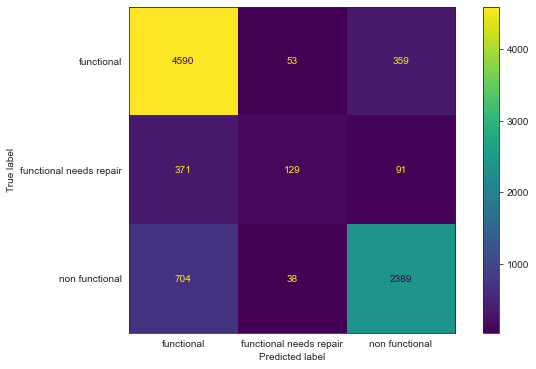

In [943]:
fig, ax = plt.subplots(figsize = (10,6))

plot_confusion_matrix(rfc_model_final, X_test, y_test, ax = ax);

In [1022]:
rfc_final.score

0.8147638697845025

In [1023]:
baseline.score

0.573360843649702

# Feature Importance

In [264]:
rfc_model_final['rfc']

RandomForestClassifier(max_depth=50, min_samples_split=5, n_jobs=-1,
                       random_state=42)

In [732]:
# Pulling transformed categorical features
tf_names = CT.named_transformers_['subpipe_cat']['ohe'].get_feature_names().tolist()

# Creating full list of features
features_t = df_num.copy()
features_t.extend(tf_names)

In [878]:
important_featured = {name: score 
                       for name, score 
                          in zip(features_t, rfc_model_final['rfc'].feature_importances_)}
#                            in zip(X_train.columns, rfc_model_final['rfc'].feature_importances_)}

# Sorting list of important features
sorted_if = sorted(important_featured.items(), key= lambda x: x[1], reverse = True)

# Top 15 Important Features
im_df = pd.DataFrame(sorted_if[:12], columns=['Feature Name','Feature Importance'])

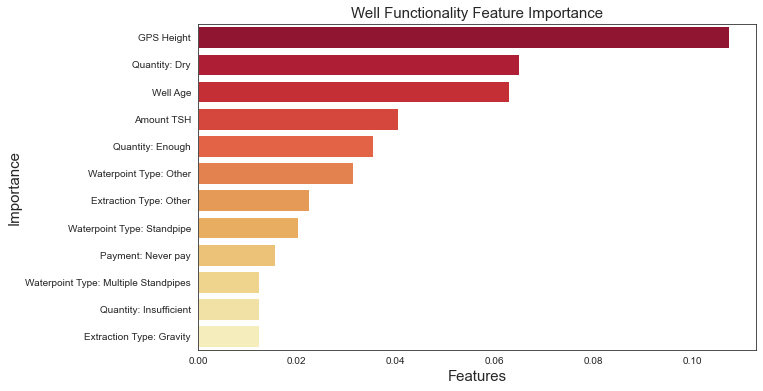

In [1014]:
# Ploting Feature Importance
# import branca.colormap as cm
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.barplot(x=im_df['Feature Importance'], y=im_df['Feature Name'], palette= 'YlOrRd_r')
ax.set_title('Well Functionality Feature Importance', fontsize=15)
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Importance', fontsize=15)

# Changing Feature names

new_names = ['GPS Height', 'Quantity: Dry', 'Well Age', 'Amount TSH', 'Quantity: Enough',
             'Waterpoint Type: Other', 'Extraction Type: Other','Waterpoint Type: Standpipe',
            'Payment: Never pay', 'Waterpoint Type: Multiple Standpipes', 'Quantity: Insufficient',
            'Extraction Type: Gravity']
ax.set_yticklabels(new_names);

plt.savefig('feature_importance.png', dpi=100, bbox_inches='tight')

# Futher analysis
- Looking further for the wells that are recommened to needing repair, remove wells with a 0.0 TSH values
- predict if or when a well will run dry, can be important to determine if its worth fixing a well.

- Additionally rerun the grid search with a better scoring metric such as scoring='recall'


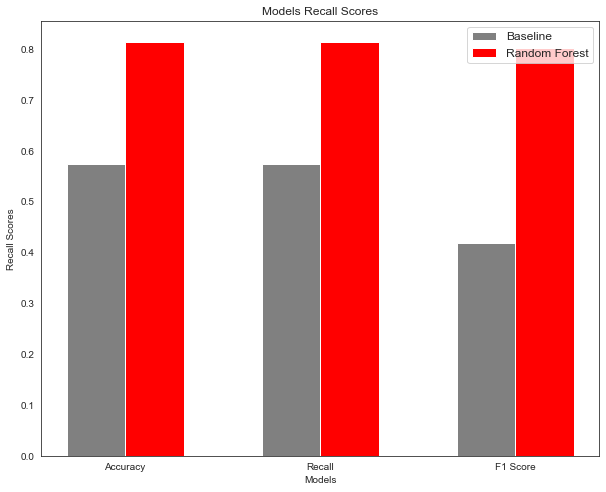

In [1015]:
fig, ax = plt.subplots(figsize= (10,8))


width = .3

f1 = np.arange(3) 
f2 = [x + width for x in f1]

ax.bar(f1, [baseline.test_recall, baseline.test_accuracy, baseline.test_f1], width, label='Baseline', color='grey')

ax.bar(f2, [rfc_final.test_recall, rfc_final.test_accuracy, rfc_final.test_f1], 
       width, label='Random Forest', color='red')





# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Recall Scores')
ax.set_title('Models Recall Scores')

ax.set_xticks(f1 + width/2)
ax.set_xticklabels(['Accuracy', 'Recall','F1 Score'])

ax.legend(fontsize=12,loc='upper right');

plt.savefig('scores.png', dpi=100, bbox_inches='tight')

# Conclusion

When comparing the accuracy and recall scores from the baseline model to the final model, 

Baseline:
- Accuracy - 57%
- Recall - 57%

Final Model:
- Accuracy - 81%
- Recall - 81%

The final model used a random forest with optimized parameters. This model can be used to predict is a well is functional, non functional, or functional and needs repair. Safe access to clean water is a basic human right, these wells are important to ensuring that this human right is met. My model can help the Tanzanian government determine if a well needs to be fixed. 